To make a bot-financial manager, that can decide whether to buy, sell, or pass stocks, we should first import all libraries

In [2]:
import yfinance as yf
import pandas as pd
import ta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter
import telebot
from telebot import types

Now let's get the info about the stock, particularly based on RSI and MACD indicators

In [3]:
data = yf.Ticker('MSFT').history(period='1y').reset_index()
data['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# plt.plot(data['Date'], data['rsi'])

Here we use matplotlib to get the 1 year history graph of the stock

([], [])

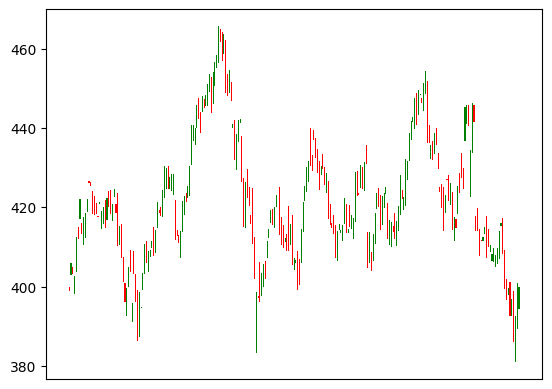

In [13]:
data.columns = data.columns.str.lower()
width = .6
width2 = .3
up = data[data['close'] >= data['open']]
down = data[data['close'] < data['open']]

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
plt.bar(up.index, up.close - up.open, width, bottom=up.open, color=col1)
plt.bar(up.index, up.high - up.close, width2, bottom=up.close, color=col1)
plt.bar(up.index, up.low - up.open, width2, bottom=up.open, color=col1)

#plot down prices
plt.bar(down.index, down.close - down.open, width, bottom=down.open, color=col2)
plt.bar(down.index, down.high - down.open, width2, bottom=down.open, color=col2)
plt.bar(down.index, down.low - down.close, width2, bottom=down.close, color=col2)
plt.xticks([])
#display candlestick chart
# plt.show()

Using the latest RSI and MACD data, we make our decision to buy, sell or  pass.
If both macd and rsi show bullish momentum, we will buy
If both show bearish momentum, we will sell,
Otherwise, we do not recommend to do anything

In [14]:
data['macd'] = ta.trend.MACD(data['close']).macd_diff()
latest = data[['macd', 'rsi']].iloc[-3:]

# plt.plot(data['macd'])

In [15]:
macd_buydecision = (latest['macd'].iloc[-1] - latest['macd'].iloc[-3] > 0) & (latest['macd'].iloc[-1] < 2)
rsi_buydecision = (latest['rsi'].mean() < 35) & (latest['rsi'].iloc[-1] - latest['rsi'].iloc[-3] > 3)

macd_selldecision = (latest['macd'].iloc[-1] - latest['macd'].iloc[-3] < 0) & (latest['macd'].iloc[-1] > -2)
rsi_selldecision = (latest['rsi'].mean() > 70) & (latest['rsi'].iloc[-1] - latest['rsi'].iloc[-3] < 3)

Since we have all required info with decisions based on MSFT stock, we can finally build our Telegram bot

In [17]:
token = 'YOUR_TOKEN'
bot = telebot.TeleBot(token)
@bot.message_handler(commands=['start'])
def start_message(message):
  bot.send_message(message.chat.id,"Hi, I'm your pesonal Financial Manager. I'm here to help you decide which popular stock to buy, to sell, or simply pass and wait for another moment. First, let's decide which stock to buy.")
  markup=types.ReplyKeyboardMarkup(resize_keyboard=True)
  item1=types.KeyboardButton("NVDA")
  markup.add(item1)
  item2=types.KeyboardButton("INTC")
  markup.add(item2)
  item3=types.KeyboardButton("TSLA")
  markup.add(item3)
  item4=types.KeyboardButton("BABA")
  markup.add(item4)
  item5=types.KeyboardButton("AAPL")
  markup.add(item5)
  item6=types.KeyboardButton("AMZN")
  markup.add(item6)
  bot.send_message(message.chat.id,'If you are willing to invest in another stock, just write it',reply_markup=markup)

@bot.message_handler(content_types='text')
def message_reply(message):
  #Here we get the data
    data = yf.Ticker(message.text).history(period='1y').reset_index()
    data['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
    data['macd'] = ta.trend.MACD(data['Close']).macd_diff()
    latest = round(data[['macd', 'rsi']].iloc[-3:], 2)

    #Based on the latest data, we form decision to do
    macd_buydecision = (latest['macd'].iloc[-1] - latest['macd'].iloc[-3] > 0)
    rsi_buydecision = (latest['rsi'].mean() < 35)

    macd_selldecision = (latest['macd'].iloc[-1] - latest['macd'].iloc[-3] < 0)
    rsi_selldecision = (latest['rsi'].mean() > 70)

    #The 1year graph
    data.columns = data.columns.str.lower()
    width = .4
    width2 = .05
    up = data[data['close'] >= data['open']]
    down = data[data['close'] < data['open']]
    col1 = 'green'
    col2 = 'red'
    plt.title(message.text)
    plt.bar(up.index, up.close - up.open, width, bottom=up.open, color=col1)
    plt.bar(up.index, up.high - up.close, width2, bottom=up.close, color=col1)
    plt.bar(up.index, up.low - up.open, width2, bottom=up.open, color=col1)
    plt.bar(down.index, down.close - down.open, width, bottom=down.open, color=col2)
    plt.bar(down.index, down.high - down.open, width2, bottom=down.open, color=col2)
    plt.bar(down.index, down.low - down.close, width2, bottom=down.close, color=col2)
    plt.xticks([])
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x}'))
    plt.savefig('graph.png')
    plt.close()

    #data-driven decision
    if macd_buydecision and rsi_buydecision:
        bot.send_message(message.chat.id, f'Having applied some basic technical analysis(RSI LEVEL:{latest['rsi'].iloc[-1]}), my suggestion is to buy it as I noticed some possible bullish momentum, but you final decision still stays on you.')
        bot.send_photo(message.chat.id, open('graph.png', 'rb'))
        bot.send_message(message.chat.id, "Here is the 1 year graph of the stock. Don't forget that technical analysis is more about trading, and not investments. This analysis is for much faster flow of money")

    elif macd_selldecision and rsi_selldecision:
        bot.send_message(message.chat.id, f'Using basic technical analysis(RSI({latest['rsi'].iloc[-1]}) and MACD indicators), my choice is to sell it as I noticed some possible bearish momentum, but you final decision still stays on you.')
        bot.send_photo(message.chat.id, open('graph.png', 'rb'))
        bot.send_message(message.chat.id, "Here is the 1 year graph of the stock. Don't forget that technical analysis is more about trading, and   not investments. This analysis is for much faster flow of money")

    else:
        bot.send_message(message.chat.id, f'Honestly, I would not recommend to invest in this stock, because it shows some unsure momentum(RSI LEVEL:{latest['rsi'].iloc[-1]}), thus think of another stock, or wait until there is better time')
        bot.send_photo(message.chat.id, open('graph.png', 'rb'))
        bot.send_message(message.chat.id, "Here is the 1 year graph of the stock. Don't forget that technical analysis is more about trading, and not investments. This analysis is for much faster flow of money. If you want to invest in this stock for years, you can try smaller amount of money")
bot.infinity_polling()

ValueError: Token must contain a colon